# Credit Risk Prediction with Random Forest Classifier

This notebook explores the performance of the Random Forest algorithm on the cleaned LendingClub dataset. Random Forests are powerful, ensemble-based classifiers that can handle both non-linear relationships and high-dimensional data. In this notebook, we:

- Load and sample the preprocessed dataset
- Split the data into training and test sets
- Tune hyperparameters using `GridSearchCV` on a smaller sample
- Train the final model on a larger sample
- Evaluate model performance using standard classification metrics

## Random Forest Classification Explanation

The **Random Forest Classifier** is a powerful ensemble learning algorithm used for classification tasks. It builds upon the decision tree algorithm by combining the predictions of multiple decision trees to produce more accurate and robust results. Instead of relying on a single decision tree, the model trains multiple trees on random subsets of the data and features, then aggregates their predictions using majority voting.

Random Forest is particularly well-suited for credit risk prediction problems because:
- It handles **high-dimensional datasets** effectively.
- It captures **nonlinear relationships** between features.
- It is **less prone to overfitting** compared to individual decision trees, especially when tuned properly.
- It provides **feature importance scores**, which help interpret which variables are most influential in the model’s decisions.

Unlike logistic regression, Random Forest does **not require feature scaling**, and it performs well even when the data includes both numerical and categorical variables (after encoding). However, it can be **computationally intensive** on large datasets, especially with a large number of trees or deep trees.

In this notebook, we will:
1. Train a Random Forest model on the preprocessed LendingClub data.
2. Evaluate its performance using classification metrics and visualization.
3. Compare its results to logistic regression to understand its advantages and tradeoffs.


In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

import time

## Load Data

We begin by loading the cleaned dataset from the previous preprocessing notebook. To keep training times reasonable and to compare results consistently across models, we sample 500,000 rows from the dataset.


In [2]:
# Load cleaned and encoded dataset
df_encoded = pd.read_csv('../data/cleaned_credit_data.csv')
print(f"Total rows in dataset: {df_encoded.shape[0]}")

Total rows in dataset: 1345310


## GridSearchCV

Before training the full model, we perform hyperparameter tuning using `GridSearchCV` on a smaller 50,000-row sample. This allows us to explore combinations of `n_estimators`, `max_depth`, `min_samples_leaf`, and `class_weight` without excessive computation time. The best parameters are then used for the final model.

### Sample Data

In [3]:
# Sample 50,000 rows for hyperparameter tuning
df_grid = df_encoded.sample(n=50000, random_state=42)

# Split into features and target
X_grid = df_grid.drop('default', axis=1)
y_grid = df_grid['default']

### Split Into Training and Test Sets

In [4]:
# Split into training and test sets
X_train_grid, X_test_grid, y_train_grid, y_test_grid = train_test_split(
    X_grid, y_grid,
    test_size=0.2,
    stratify=y_grid,
    random_state=42
)

### Scale Features

In [5]:
# Fit only on training set
scaler_grid = StandardScaler()
X_train_grid_scaled = scaler_grid.fit_transform(X_train_grid)
X_test_grid_scaled = scaler_grid.transform(X_test_grid)

### Run GridSearchCV

In [6]:
# Define parameters to be tested
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [5, 10],
    'class_weight': [{0: 1, 1: 3}, {0: 1, 1: 5}]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_grid_scaled, y_train_grid)

print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

# Save best params
best_params = grid_search.best_params_


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END class_weight={0: 1, 1: 3}, max_depth=10, min_samples_leaf=10, n_estimators=100; total time=   9.4s
[CV] END class_weight={0: 1, 1: 3}, max_depth=10, min_samples_leaf=10, n_estimators=100; total time=   9.4s
[CV] END class_weight={0: 1, 1: 3}, max_depth=10, min_samples_leaf=10, n_estimators=100; total time=   9.5s
[CV] END class_weight={0: 1, 1: 3}, max_depth=10, min_samples_leaf=5, n_estimators=100; total time=   9.6s
[CV] END class_weight={0: 1, 1: 3}, max_depth=10, min_samples_leaf=5, n_estimators=100; total time=   9.6s
[CV] END class_weight={0: 1, 1: 3}, max_depth=10, min_samples_leaf=5, n_estimators=100; total time=   9.6s
[CV] END class_weight={0: 1, 1: 3}, max_depth=10, min_samples_leaf=5, n_estimators=200; total time=  15.0s
[CV] END class_weight={0: 1, 1: 3}, max_depth=10, min_samples_leaf=5, n_estimators=200; total time=  15.6s
[CV] END class_weight={0: 1, 1: 3}, max_depth=10, min_samples_leaf=5, n_estimat

## Random Forest Classifier

Using the best parameters from the grid search, we now train the final Random Forest classifier on a larger 500,000-row sample. We use all available cores for faster training.


### Sample Data (500,000 rows)

In [7]:
# Sample 500,000 rows for final training
df_final = df_encoded.sample(n=500000, random_state=42)

X = df_final.drop('default', axis=1)
y = df_final['default']

### Split Into Training and Test Sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### Scale Features

In [9]:
# Scale with new scaler (fit only on training set)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train Classifier

In [10]:
# Initialize model with best hyperparameters from GridSearchCV
final_model = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

start = time.time()
final_model.fit(X_train_scaled, y_train)
end = time.time()

print(f"Training time: {end - start:.2f} seconds")


Training time: 51.24 seconds


### Evaluate Model Performance

We check accuracy, precision, recall, F1-score, and ROC AUC.


In [11]:
y_pred = final_model.predict(X_test_scaled)
y_proba = final_model.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[66959 13115]
 [11498  8428]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     80074
           1       0.39      0.42      0.41     19926

    accuracy                           0.75    100000
   macro avg       0.62      0.63      0.63    100000
weighted avg       0.76      0.75      0.76    100000

ROC AUC Score: 0.716303317002785


## Interpretation

- **Precision (Class 1)**: Out of all predicted defaults, how many were actually defaults.
- **Recall (Class 1)**: Out of all true defaults, how many the model caught.
- **F1-score (Class 1)**: Balance of precision and recall.
- **ROC AUC**: Overall ability of the model to separate defaulters from non-defaulters.

These metrics are especially important in **credit risk** where:
- False positives = denying a good borrower
- False negatives = approving a risky borrower

We aim to **maximize recall** while keeping decent precision.


### Random Forest Results (Sample Size: 500,000)

After tuning the model using `GridSearchCV` on a 50,000-row sample and training on a larger sample of 500,000 rows, the Random Forest classifier achieved **moderate performance** on the credit risk prediction task. Training with class weights to address class imbalance and using the best-found hyperparameters led to a final model with an **overall accuracy of 75%**.

From the **confusion matrix**, we can observe that the model correctly classified **66,959 fully paid loans** and **8,428 defaults**, while it misclassified **13,115 paid loans as defaults** and **11,498 defaults as paid**. This imbalance in predictive power is reflected in the **classification report**:  
- Precision for the default class was **0.39**, meaning that 39% of predicted defaults were correct.  
- Recall was **0.42**, indicating that 42% of actual defaults were successfully identified.  
- The **F1-score** for the default class (which balances precision and recall) was **0.41**.

While not perfect, the model still captures a meaningful portion of default cases, and the **ROC AUC score of 0.716** confirms that the model performs substantially better than random guessing, but with clear room for improvement.

This model provides a solid benchmark for tree-based methods and highlights the potential for further optimization using techniques such as ensemble boosting (e.g., XGBoost, LightGBM), feature selection, or cost-sensitive learning strategies.


# Credit Risk Prediction with Random Forest Classifier Results

## Confusion Matrix

The confusion matrix provides a detailed breakdown of predicted vs. actual classifications. It helps us understand how well the model distinguishes between repaid and defaulted loans, including false positives (predicting default when the loan is actually repaid) and false negatives (failing to catch a true default).


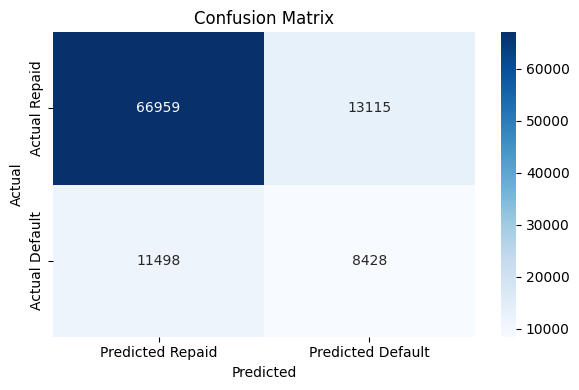

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Repaid', 'Predicted Default'],
            yticklabels=['Actual Repaid', 'Actual Default'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of the Random Forest model’s classification performance for repaid and defaulted loans. Each cell represents a combination of actual and predicted labels:

- **True Negatives (Top-Left: 66,959)**: Loans that were actually repaid and correctly predicted as repaid.
- **False Positives (Top-Right: 13,115)**: Loans that were actually repaid but incorrectly predicted as defaults.
- **False Negatives (Bottom-Left: 11,498)**: Loans that actually defaulted but were misclassified as repaid.
- **True Positives (Bottom-Right: 8,428)**: Loans that defaulted and were correctly predicted as such.

From this matrix, we can see that the model correctly identified a large majority of repaid loans (**66,959 true negatives**) but struggled more with detecting defaults, achieving only **8,428 true positives** while missing **11,498 defaulters**. This suggests that the model favors predicting repayment, which boosts overall accuracy but reduces recall for the minority (default) class.

The relatively high number of false negatives is a concern in credit risk modeling, as these represent risky loans that would be wrongly approved. On the other hand, the lower false positive count (**13,115**) compared to logistic regression means fewer repaid loans are unnecessarily flagged as high risk, potentially preserving more lending opportunities. This trade-off reflects the Random Forest’s stronger precision for defaults but weaker recall, highlighting the importance of aligning model tuning with the business’s tolerance for different types of errors.


## ROC Curve and AUC Score

The ROC (Receiver Operating Characteristic) curve visualizes the trade-off between the true positive rate (recall) and the false positive rate across different classification thresholds. The Area Under the Curve (AUC) quantifies this performance — a higher AUC means the model is better at distinguishing between classes.

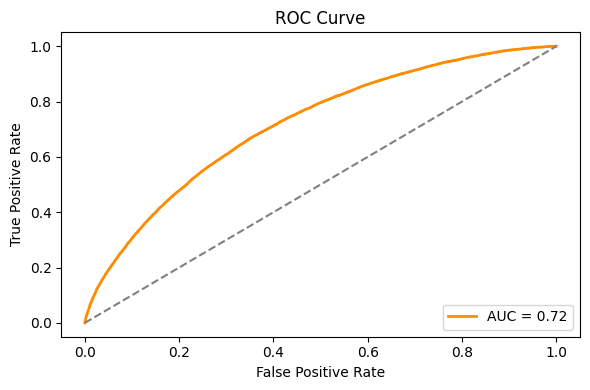

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### ROC Curve Analysis  

The ROC curve provides a visual representation of the trade-off between the **True Positive Rate (Recall)** and the **False Positive Rate** at various classification thresholds. The curve shown here demonstrates that the Random Forest model performs significantly better than random guessing (represented by the diagonal dashed line).  

With an **AUC score of 0.72**, the model shows a moderate ability to distinguish between default and non-default cases. While not perfect, this is a substantial improvement over chance (AUC = 0.50) and indicates that the model captures meaningful patterns in the data.  

The shape of the curve suggests that the model maintains a reasonable recall for defaulters while controlling the false positive rate up to a certain threshold. However, the curve does not approach the top-left corner as closely as high-performing models would, signaling room for improvement — potentially through further feature engineering, hyperparameter tuning, or using more advanced ensemble methods.  

In practice, this AUC value means that if we randomly select one defaulted loan and one repaid loan, the model will correctly rank the defaulted loan as higher risk about **72% of the time**. This makes it a useful, though not flawless, tool for credit risk prediction.  

## Precision-Recall Curve

This curve is especially useful for imbalanced datasets. It shows the trade-off between precision (how many predicted defaults were correct) and recall (how many actual defaults were caught). A good model tries to keep both high.

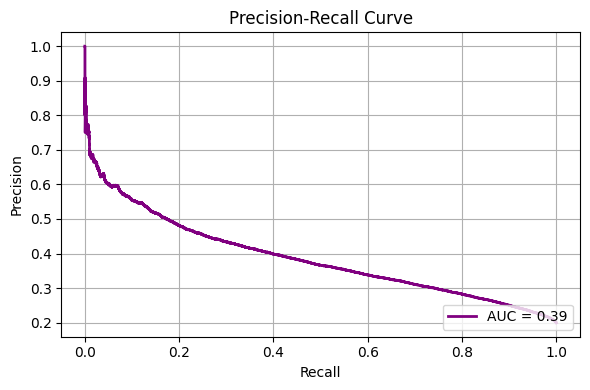

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score


precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, lw=2, color='purple', label=f'AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Precision-Recall Curve Analysis  

The Precision-Recall (PR) curve provides deeper insight into the model's performance on imbalanced datasets, where the positive class (loan defaults) is much less frequent than the negative class (loan repayments).  

With an **AUC score of 0.39**, the Random Forest model demonstrates limited effectiveness in maintaining high precision while capturing a substantial proportion of actual defaulters. At very high recall values, precision drops significantly, indicating that as the model tries to catch more defaulters, it introduces many false positives. Conversely, when precision is high, recall is extremely low, meaning that the model is identifying only a small fraction of true defaulters.  

The steep decline from high precision at very low recall highlights that the model can confidently identify a small subset of defaults but struggles to generalize this accuracy across the entire population of defaulters.  

In the context of credit risk modeling, this curve suggests a trade-off:  
- **Higher precision** reduces the risk of wrongly flagging good customers but misses many actual defaulters.  
- **Higher recall** catches more defaulters but at the cost of incorrectly classifying many non-defaulters.  

Given the relatively modest AUC score, further work on feature engineering, resampling strategies (e.g., SMOTE), or advanced algorithms could improve the balance between precision and recall for this task.  
